# 01 – Data Exploration

In this notebook we will:

1. Load our train / validation / test splits  
2. Confirm data integrity (no missing values, correct columns)  
3. Spot-check random examples per emotion  
4. Examine class distributions per split (Seaborn plots)  
5. (Optional) Inspect text-length distributions  

All data files were generated by `scripts/1_load_data.py`.


In [1]:
# — Imports & Setup
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Seaborn styling
%matplotlib inline
sns.set_theme(style="whitegrid")

# Point to data directory
DATA_DIR = Path.cwd().parent / "data"

c:\Users\Inbal\anaconda3\envs\env_emotion_detection\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load CSV Splits via `datasets`

We’ll use `load_dataset("csv", …)` to pull in our local files as a DatasetDict.

In [2]:
# — Load local CSVs
ds = load_dataset("csv", data_files={
    "train": str(DATA_DIR / "train.csv"),
    "validation": str(DATA_DIR / "validation.csv"),
    "test": str(DATA_DIR / "test.csv")
})

# Inspect dataset sizes and columns
print(ds)

Generating train split: 16000 examples [00:00, 479990.16 examples/s]
Generating validation split: 2000 examples [00:00, 266753.84 examples/s]
Generating test split: 2000 examples [00:00, 269955.85 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'emotion'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'emotion'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'emotion'],
        num_rows: 2000
    })
})


Now convert each split into a pandas DataFrame for detailed inspection.

In [3]:
# — To pandas
df_train = ds["train"].to_pandas()
df_val   = ds["validation"].to_pandas()
df_test  = ds["test"].to_pandas()

print("Train:", df_train.shape, "| Validation:", df_val.shape, "| Test:", df_test.shape)

Train: (16000, 2) | Validation: (2000, 2) | Test: (2000, 2)


## 2. Data Integrity Checks

Ensure each DataFrame has:
- Exactly two columns: `text` and `label`  
- No missing values  
- Correct data types

In [4]:
# Column names and types
display(df_train.dtypes)

# Missing values
for split, df in [("train", df_train), ("validation", df_val), ("test", df_test)]:
    print(f"{split}: {df.isna().sum().sum()} missing values")

text       object
emotion    object
dtype: object

train: 0 missing values
validation: 0 missing values
test: 0 missing values


> **Observation:** 
No missing values; columns `text` (string) and `emotion` (string) look correct.

## 3. Spot-Check Random Examples

View random text per emotion from the training set to manually verify quality.

In [5]:
n_samples = 3  # Number of examples to sample per emotion

for emotion in sorted(df_train.emotion.unique()):
    print(f"--- {emotion.upper()} ---")
    samples = df_train[df_train.emotion == emotion].sample(n_samples, random_state=42)
    for idx, row in samples.iterrows():
        print(f"# {row.text}")
    print("\n")


--- ANGER ---
# i ve been feeling a bit cranky with the kids this week cranky baby whiny year old demanding preschooler so i wanted to stop and remember how blessed i really am
# i feel frustrated sometimes with my mac lipsticks when i have to read names or open each of them to select shade
# i feeling stressed


--- FEAR ---
# i can feel the frantic beat of his heart but cookie s voice is surprisingly clear
# i feel a little suspicious
# i can t help but feeling weird when opening every closet in an apartment that somebody s still living in so i didn t


--- JOY ---
# i feel im rather innocent in that respect
# im feeling quite adventurous and tried out those drinks that i just normally read through the pages of pocketbooks
# im feeling much more positive about the impending move


--- LOVE ---
# i mean fuck i feel like i was way more considerate with customers and concerned about appearance and sanitiation snoozel pm but fine
# i remember a couple of years ago i was feeling romantic 

> **Observations**  
>  
> 1. **All lowercase**  
>    Every example is in lowercase, even proper names and sentence starts.  
>  
> 2. **Missing punctuation & apostrophes**  
>    - No commas, periods, question marks, or apostrophes in any sample.  
>    - Contractions like “I’m” appear as “im”, and possessives like “someone’s” as “somebody s”.  
>  
> 3. **Typos and irregular spacing**  
>    - Words run together or are split by extra spaces (e.g. “sanitiation snoozel pm”).  
>    - A few clear misspellings (“sanitiation”, “impend­ing”).  
>  
> 4. **Grammatical fragments**  
>    - Some fragments lack verbs or have truncated clauses (“i feeling stressed”).  
>    - One “sadness” entry is completely empty (noted as `…`).  
>  
> 5. **Informal or profane language**  
>    - Expletives (“fuck”) appear in the “love” samples—this may be noise or a signal depending on your chosen approach.  
>  ---
> **Implications & Next Steps**  
>  
> - **Normalization & Cleaning**  
>   - Expand contractions (`im` → `I’m`, `dont` → `don’t`).  
>   - Correct common typos and remove extra spaces.  
>   - Optionally mask or handle profanity.  
>  
> - **Drop Invalid Rows**  
>   - Remove any rows where `text` is empty or extremely short (e.g. <3 characters).  
>  
> - **Tokenization Strategy**  
>   - Rely on a subword tokenizer (e.g. BERT’s WordPiece) that handles run-on text.  
>   - Consider re-inserting a sentence terminator (period) at the end of each text.  
>  
> - **Re-evaluate Distributions**  
>   - After cleaning, rerun class-balance and length-distribution plots to confirm no unintended skew.  
>  ---
> **Action Plan**
>  
> 1. **Add a “Cleaning” section** below that applies a `clean_text()` function to each split.  
> 2. **Implement `clean_text()`** in your data preparation script to handle contractions, typos, punctuation, and empty strings.  
> 3. **Reload & explore** the cleaned data in this notebook (update DataFrames).  
> 4. **Proceed to Section 4** (TF–IDF Baseline) using the cleaned `text` column as input.  
> <br>


## 4. Class Distribution per Split

Visualize how many examples of each emotion appear in each split.

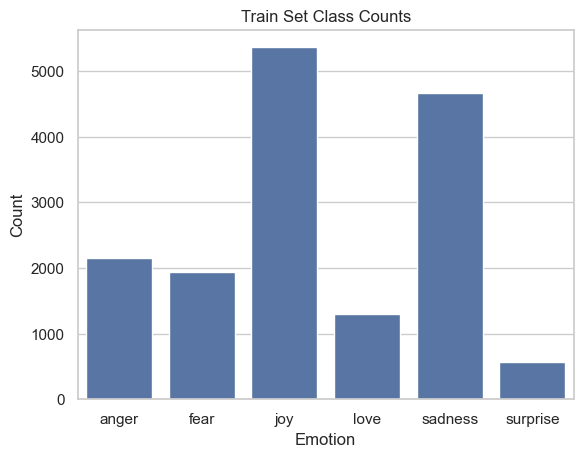

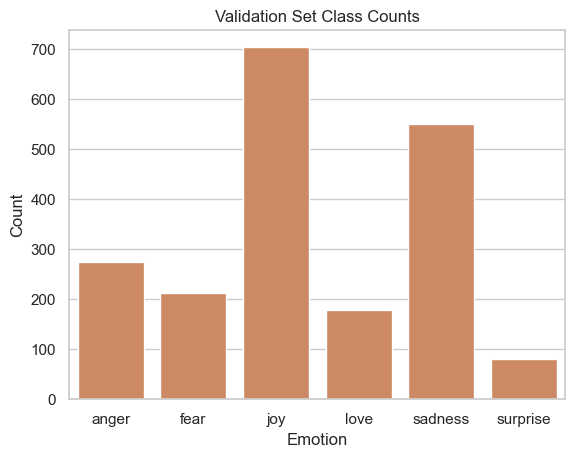

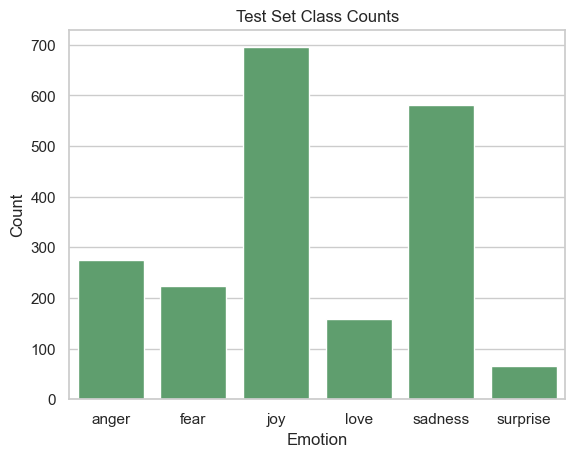

In [21]:
def plot_counts(df, title, color):
    sns.countplot(x="emotion", data=df, order=sorted(df.emotion.unique()), color=color)
    plt.title(title)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.show()

plot_counts(df_train, "Train Set Class Counts", color="C0")
plot_counts(df_val,   "Validation Set Class Counts", color="C1")
plot_counts(df_test,  "Test Set Class Counts", color="C2")

> **Observation:**  
> The train/validation/test splits maintain the same relative proportions (i.e. they’re stratified), but the overall dataset is imbalanced: “joy” is the largest class, “surprise” the smallest, with the others in between.  
>  
> **Strategies for Handling Class Imbalance:**  
>  
> > **A. Data‐Level Approaches**  
> > - **Oversampling**: duplicate or synthesize minority‐class examples in the training set.  
> > - **Undersampling**: down‐sample majority‐class examples to rebalance.  
>  
> > **B. Algorithm‐Level Approaches**  
> > - **Class weights**: pass `class_weight='balanced'` in scikit-learn or supply a `weight` tensor to the loss in Hugging Face’s Trainer so rare classes incur higher penalty.  
>  
> > **C. Evaluation Practices**  
> > - Use **macro-F1** (and per-class F1) instead of accuracy, ensuring each emotion counts equally in your final score.  
>  
> > **D. Documentation**  
> > - In your modeling notebooks, note which imbalance strategy you chose (oversample / class weights / both) and why, so readers can follow your rationale.  


## 5. Text-Length Distribution

Check character-length distributions to guide our max-token-length choice for transformers.


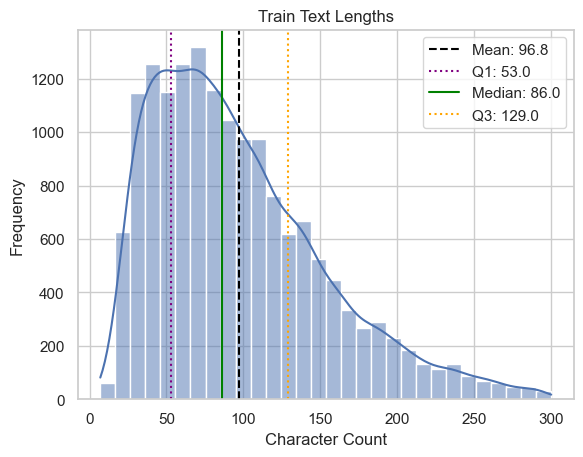

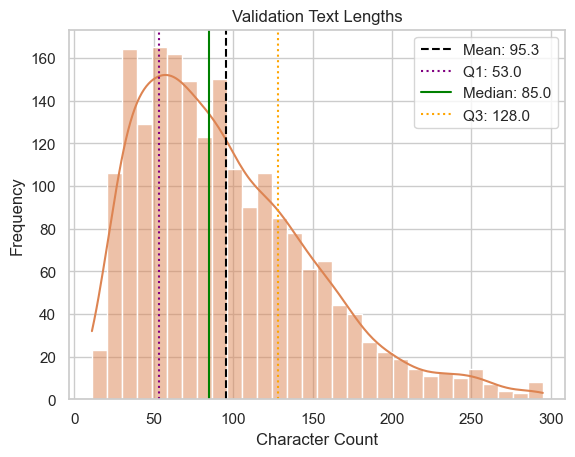

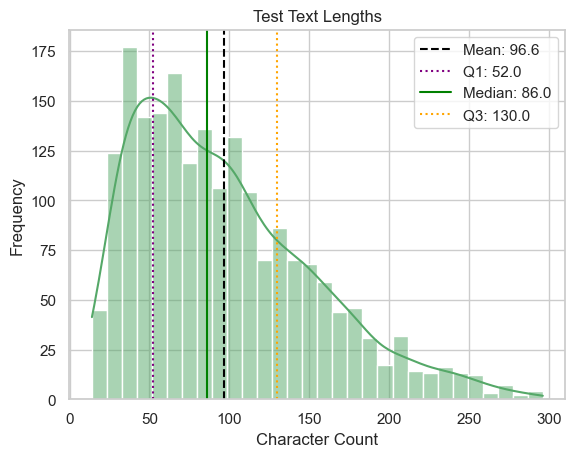

In [32]:
def plot_hist(df, title, color):
    lengths = df.text.str.len()
    
    # Calculate statistics
    mean_val = lengths.mean()
    q1 = lengths.quantile(0.25)
    median = lengths.median()
    q3 = lengths.quantile(0.75)
    
    # Plot histogram
    sns.histplot(lengths, bins=30, color=color, kde=True) 
    plt.axvline(mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.1f}')
    plt.axvline(q1, color='purple', linestyle=':', label=f'Q1: {q1:.1f}')
    plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.1f}')
    plt.axvline(q3, color='orange', linestyle=':', label=f'Q3: {q3:.1f}')
    
    # Add labels and legend
    plt.title(title)
    plt.xlabel("Character Count")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plotting
plot_hist(df_train, "Train Text Lengths", color="C0")
plot_hist(df_val,   "Validation Text Lengths", color="C1")
plot_hist(df_test,  "Test Text Lengths", color="C2")


> **Observation:**  
> - **Overall Shape**: All three datasets (Train, Validation, Test) show a right-skewed distribution, with most samples having shorter text lengths and a long tail toward higher character counts.
>
> - **Central Tendency**:
>   - The **mean** character count is around 95–97 for all splits, slightly higher than the **median** (≈85–86), reflecting the skewness.
>   - The **median** is consistently lower than the mean, confirming the presence of longer outlier texts pulling the average up.
>
> - **Spread**:
>   - **Q1** (≈52–53) and **Q3** (≈128–130) are fairly consistent across the splits.
>   - The **IQR (Q3–Q1)** is approximately 75–78 characters, showing moderate variability in text length.
>
> - **Similarity Across Splits**:
>   - All three datasets have nearly identical statistics, suggesting that the data was well-shuffled and split uniformly.
>   - This consistency supports the assumption that model training and evaluation will occur on similarly distributed text lengths.
>
> - **Skewness Impact**:
>   - The long tail on the right indicates occasional long texts. These may need to be handled (e.g., truncated, padded) if fixed-length input is required for modeling.
